# Item Based Collaborative Filtering

## Introduction

This notebook will demonstrate how to create a toy basic recommender system (RS). The RS will take as input a selected book title and based on the ratings from multiple reviewers for all other books it suggests what other books might also be interesting.

In the accompanied presentation some types of Recommender Systems are explained including a manual calculation for User and Item Based Recommenders. Below we will develop a simple Item Based Recommender.

This notebook is by no means complete. The purpose is to give a quick hands-on experience with building a data product.

### Terminology
* **Item**: The product, service or thing that will be recommended.
* **User**: A person thats reates items and gets items recommended.
* **Rating**: The preference of the user of an item. This can be binary (yes/no), a value (1 to 5 stars), amount of interactions (times played or selected).

### Approach
1. The problem / objective
2. Data exploration
3. Develop similarity function
4. Data preparation
5. Build similarity matrix
6. Create service

To start we import some python libraries that we require to run the code.

In [2]:
import pandas as pd
import numpy as np
import matplotlib
#matplotlib.use('tkagg')
import matplotlib.pyplot as plt
%matplotlib inline

## 1. The problem / objective

We are going the create a book recommender system that suggests a *top N* set of books for any chosen book.

The data we use is an anonymized dataset from [Book-Crossing](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) which is a collection of ratings for a periode of 4 weeks. Each record (row) contains the user id, book title and the given rating.

The objective is to build a service that take as input the title of a book and the amount of required recommendations.

## 2. Data exploration

Load the data into a pandas dataframe and show the first few records.

In [3]:
data = pd.read_csv("data/data_books.csv", sep = ",", header=None, names=['Reviewer', 'Book', 'Rating'])
# Let's see how the dataframe looks like
data.head()

,Reviewer,Book,Rating
0,276726,Rites of Passage,5
1,276729,Help!: Level 1,3
2,276729,The Amsterdam Connection : Level 4 (Cambridge ...,6
3,276744,A Painted House,7
4,276747,Little Altars Everywhere,9


### Show some statistics

Dimensions of the dataset.

In [4]:
dim = data.shape
print ("There are {:d} rows/records in this dataframe and {:d} columns/features.".format(dim[0], dim[1]))

There are 383852 rows/records in this dataframe and 3 columns/features.


Amount of unique books in the dataset.

In [5]:
unique_books = pd.unique(data[['Book']].values.ravel()).size
print ("{:d} unique books.".format(unique_books))

135394 unique books.


Amount of unique reviewers in the dataset.

In [6]:
unique_reviewers = pd.unique(data[['Reviewer']].values.ravel()).size
print ("{:d} unique reviewers.".format(unique_reviewers))

68092 unique reviewers.


Top 10 most reviewed books.

In [7]:
top_books = pd.value_counts(data.Book)
top_books.head(10)

The Lovely Bones: A Novel                           707
Wild Animus                                         581
The Da Vinci Code                                   494
The Secret Life of Bees                             406
The Nanny Diaries: A Novel                          393
The Red Tent (Bestselling Backlist)                 383
Bridget Jones's Diary                               377
A Painted House                                     366
Life of Pi                                          336
Harry Potter and the Chamber of Secrets (Book 2)    326
Name: Book, dtype: int64

Lets show a graph of the top 1000 most reviewed books.

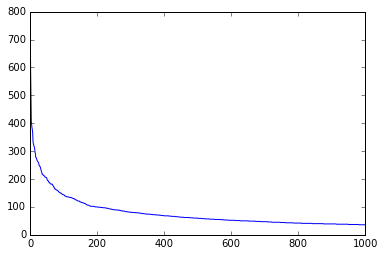

In [8]:
plt.plot(top_books[:1000].values);

Top 10 reviewers.

In [9]:
top_reviewers = pd.value_counts(data.Reviewer)
top_reviewers.head(10)

11676     6943
98391     5691
189835    1899
153662    1845
23902     1180
235105    1020
76499     1012
171118     962
16795      959
248718     941
Name: Reviewer, dtype: int64

Lets show the graph of the top 1000 reviewers.

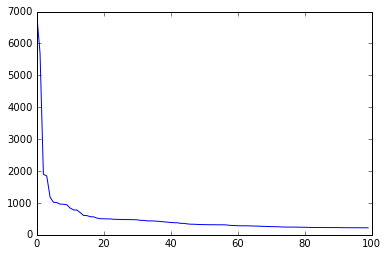

In [10]:
plt.plot(top_reviewers[:100].values);

### Sparsity

**Sparsity** is the fraction of non-empty cells over the total amount of cells in the matrix.

In [11]:
# Total matrix would be
total_cells = unique_reviewers * unique_books

# How sparse is the matrix now
perc = dim[0] / float(total_cells) * 100.
print ('{:.4f}%'.format(perc))

0.0042%


### Train and test

**Prepare the train and test datasets** and save them as files for later. For this exercise we only take the records of only those reviewers for which we have more than two reviews. The highest rated review will go into the test dataset and the other reviews will be added to the train dataset.

```python
# INFO: This is working code, but will take about 15 minutes to run
train = pd.DataFrame()
test = pd.DataFrame()

grouped = data.groupby(['Reviewer'])

for k, g in grouped:
    # We are only interested in reviewers with more than 2 reviews
    if len(g) > 2:
        print k
        g.sort_values('Rating', ascending=False, inplace=True)
        test = test.append(g.iloc[:1])
        train = train.append(g.iloc[1:])
        
train.to_csv('train_books.csv', index=False)
test.to_csv('test_books.csv', index=False)
```

In [12]:
train = pd.read_csv("../data/train_books.csv", sep = ",")
test = pd.read_csv("../data/test_books.csv", sep = ",")

In [13]:
print ('Train: {:d} (samples), Test: {:d} (samples)'.format(train.shape[0], test.shape[0]))

Train: 307086 (samples), Test: 20194 (samples)


### Data Size and performance

*For performance reasons we will select the top most reviewed books for the calculation of similarity between all book pairs will take too much time. This is the reason why these calculations are executed seperately from the online scoring mechanism.*

In [14]:
most_reviewed_books = pd.DataFrame({'count' : train.groupby(["Book"]).size()})\
                                    .reset_index().sort_values(['count'],ascending = False)

most_reviewed_books.head(10)

,Book,count
98195,The Lovely Bones: A Novel,410
91356,The Da Vinci Code,316
117982,Wild Animus,315
79028,She's Come Undone (Oprah's Book Club),307
14121,Bridget Jones's Diary,272
99728,The Nanny Diaries: A Novel,262
103608,The Secret Life of Bees,253
40283,Harry Potter and the Chamber of Secrets,253
7261,Angels & Demons,238
2748,A Painted House,233


**Question**: Why do we see less reviews for *The Lovely Bones: A Novel*?

We need these names available in a list for later use so we create a python list of the top 20 most reviewed books.

In [15]:
# Getting the list of the most reviewed books
top_books = []

for i in most_reviewed_books.Book[0:20]:
    top_books.append(i)

In [16]:
top_books

['The Lovely Bones: A Novel',
 'The Da Vinci Code',
 'Wild Animus',
 "She's Come Undone (Oprah's Book Club)",
 "Bridget Jones's Diary",
 'The Nanny Diaries: A Novel',
 'The Secret Life of Bees',
 'Harry Potter and the Chamber of Secrets',
 'Angels & Demons',
 'A Painted House',
 'Harry Potter and the Prisoner of Azkaban',
 "Harry Potter and the Sorcerer's Stone (Harry Potter)",
 'Life of Pi',
 'The Red Tent',
 'Harry Potter and the Goblet of Fire',
 'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
 'The Notebook',
 'The Testament',
 'The Summons',
 "Where the Heart Is (Oprah's Book Club)"]

## 3. Develop a similarity function

For the top rated books we need to calculate their mutual similarities.
In order to do so we will start simple by calculating the mutual similarity of two books and then generalize this for any two book. The similarity will be determined by Cosine-similarity.

$$\cos (\theta) = \frac{v \cdot w }{\left \| v \right \|*\left \| w \right \|} = \frac{\sum_{i=1}^{n} v_{i} u_{i}}{\sqrt{\sum_{i=1}^{n} v_{i}^{2}} \sqrt{\sum_{i=1}^{n} u_{i}^{2}}}$$

**How to calculate**:
1. Choose two books
2. Determine their shared reviewers (data reduction!)
3. Get for both books the reviews given by their shared reviewers
4. Calculate the Cosine-similarity of both books from these reviews

The output values are used to create the matrix with all mutual similarities.

### Step 1: Choose two books

In [17]:
book_1, book_2 = "Harry Potter and the Chamber of Secrets", "Harry Potter and the Sorcerer's Stone (Harry Potter)"

### Step 2: Determine the shared reviewers

In [18]:
# Getting all the reviewers for these books. For this we still need the train dataset as source.
book_1_reviewers = train[train.Book == book_1].Reviewer
book_2_reviewers = train[train.Book == book_2].Reviewer

# Determine any common reviewers
common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

print "%d people have reviewed both books" % len(common_reviewers)

78 people have reviewed both books


### Step 3: Get the reviews for both books given by their shared reviewers.

In [19]:
# Checking the table with only the common reviewers and get the book name and rating
com_rev_book1 = train[(train.Reviewer.isin(common_reviewers)) & (train.Book == book_1)]
com_rev_book2 = train[(train.Reviewer.isin(common_reviewers)) & (train.Book == book_2)]

Show the resulting lists.

In [20]:
com_rev_book1.head(10)

,Reviewer,Book,Rating
9448,10560,Harry Potter and the Chamber of Secrets,10
10633,11676,Harry Potter and the Chamber of Secrets,10
10702,11676,Harry Potter and the Chamber of Secrets,10
13763,11676,Harry Potter and the Chamber of Secrets,8
27668,22625,Harry Potter and the Chamber of Secrets,10
32768,26190,Harry Potter and the Chamber of Secrets,9
38375,30735,Harry Potter and the Chamber of Secrets,9
38381,30735,Harry Potter and the Chamber of Secrets,9
57981,48899,Harry Potter and the Chamber of Secrets,8
60374,51647,Harry Potter and the Chamber of Secrets,8


In [21]:
print com_rev_book1.shape

(81, 3)


In [22]:
com_rev_book2.head(10)

,Reviewer,Book,Rating
9435,10560,Harry Potter and the Sorcerer's Stone (Harry P...,10
10485,11676,Harry Potter and the Sorcerer's Stone (Harry P...,10
27660,22625,Harry Potter and the Sorcerer's Stone (Harry P...,10
32769,26190,Harry Potter and the Sorcerer's Stone (Harry P...,9
38296,30735,Harry Potter and the Sorcerer's Stone (Harry P...,10
57982,48899,Harry Potter and the Sorcerer's Stone (Harry P...,8
60373,51647,Harry Potter and the Sorcerer's Stone (Harry P...,10
64897,55492,Harry Potter and the Sorcerer's Stone (Harry P...,10
67000,56447,Harry Potter and the Sorcerer's Stone (Harry P...,7
68212,57398,Harry Potter and the Sorcerer's Stone (Harry P...,10


In [23]:
print com_rev_book2.shape

(78, 3)


We see **duplicate reviewers**, that must be fixed to calculate the Cosine-similarity as we need two vectors of the same size. The code below will remove all duplicates and we choose to keep the first record of the duplicate set.

In [24]:
# Fix the duplicates to prevent errors when calculating Pearson-correlation.
com_rev_book1.sort_values('Reviewer')
com_rev_book1 = com_rev_book1[com_rev_book1.Reviewer.duplicated()==False]

com_rev_book1.sort_values('Reviewer')
com_rev_book1 = com_rev_book1[com_rev_book1.Reviewer.duplicated()==False]

### Step 4: Calculate the similarity

Looking at the formula we see a _numerator_ part and a _denominator_ part. Lets perform this calculation piece by piece.

In [25]:
numerator = np.dot(com_rev_book1.Rating, com_rev_book2.Rating)

In [26]:
book1_dot = np.dot(com_rev_book1.Rating,com_rev_book1.Rating)
book2_dot = np.dot(com_rev_book2.Rating,com_rev_book2.Rating)

denominator = np.math.sqrt(book1_dot * book2_dot)

So the Cosine-similarity value is:

In [27]:
similarity = numerator / denominator
similarity

0.99734456905443669

Now we have two books that look quit correlated or similar.

### Step 5: Create a reusable function

In order to calculate the similarity for any two books we need to build two functions that will make our live much more easy.

1. A function that helps us to retrieve the reviews for a specific book given a shared set of reviewers with another book
2. A function that helps us calculating the Cosine similarity for two books.

In [28]:
# First let's create a function that collects the reviews of our common reviewers for a specified book
def get_book_reviews(title, common_reviewers):
    mask = (train.Reviewer.isin(common_reviewers)) & (train.Book==title)
    reviews = train[mask].sort_values('Reviewer')
    reviews = reviews[reviews.Reviewer.duplicated()==False]
    return reviews

In [29]:
# Put all calculations of the Cosine-similarity in one function
def cosin_sim(v, w):
    return np.dot(v, w) / np.math.sqrt(np.dot(v, v) * np.dot(w, w))

In [30]:
cosin_sim(com_rev_book1.Rating, com_rev_book2.Rating)

0.99734456905443669

Lets check this with the baseline similarity score.

In [31]:
cosin_sim(com_rev_book1.Rating, com_rev_book2.Rating) == similarity

True

Check that we get the same correlation as we had before.

In [32]:
def calculate_cosine_similarity(book1, book2):
    # We start by finding the common reviewers
    book_1_reviewers = train[train.Book == book1].Reviewer
    book_2_reviewers = train[train.Book == book2].Reviewer
    common_reviewers = set(book_1_reviewers).intersection(book_2_reviewers)

    # Then we look for the reviews given by common reviewers
    book_1_reviews = get_book_reviews(book1, common_reviewers)
    book_2_reviews = get_book_reviews(book2, common_reviewers)
    
    # Calculate the similarity score
    return cosin_sim(book_1_reviews.Rating, book_2_reviews.Rating)

In [33]:
# Print the correlation score
calculate_cosine_similarity(book_1,book_2)

0.99734456905443669

In [34]:
calculate_cosine_similarity(book_1,book_2) == similarity

True

## 5. Build the similarity matrix

**Note**: Calculating these similarities in real-time and for many users in parallel will require huge computation power. But this type of Recommender System (Item Based) has the advantage to have the mutual book similarities been pre calculated.

Lets do that!

Build the matrix with all mutual similarities.

In [35]:
# calculate the correlation for our top books
similarity_matrix = []

for book1 in top_books:
    print "Calculating the similarities for:", book1
    for book2 in top_books:
        if book1 != book2:
            row = [book1, book2] + [calculate_cosine_similarity(book1, book2)]
            similarity_matrix.append(row)
            
print "Done calculating."

Calculating the similarities for: The Lovely Bones: A Novel
Calculating the similarities for: The Da Vinci Code
Calculating the similarities for: Wild Animus
Calculating the similarities for: She's Come Undone (Oprah's Book Club)
Calculating the similarities for: Bridget Jones's Diary
Calculating the similarities for: The Nanny Diaries: A Novel
Calculating the similarities for: The Secret Life of Bees
Calculating the similarities for: Harry Potter and the Chamber of Secrets
Calculating the similarities for: Angels & Demons
Calculating the similarities for: A Painted House
Calculating the similarities for: Harry Potter and the Prisoner of Azkaban
Calculating the similarities for: Harry Potter and the Sorcerer's Stone (Harry Potter)
Calculating the similarities for: Life of Pi
Calculating the similarities for: The Red Tent
Calculating the similarities for: Harry Potter and the Goblet of Fire
Calculating the similarities for: Divine Secrets of the Ya-Ya Sisterhood: A Novel
Calculating the

The resulting dictionary is converted back into a pandas DataFrame to make it more easy to access.

In [36]:
# Define the columns to use
cols = ["Book_1", "Book_2", "Similarity"]
similarity_matrix = pd.DataFrame(similarity_matrix, columns=cols).sort_values('Similarity')
#correlation_coefficient.head(10)

**Question**: what is the size of similarity matrix?

In [37]:
similarity_matrix.shape

(380, 3)

In [38]:
# sim_mat is the pre calculated similarity matrix
def calc_similarity(sim_mat, book1, book2):
    mask = (sim_mat.Book_1==book1) & (sim_mat.Book_2==book2)
    row = sim_mat[mask]
    return row.sum(axis=1).tolist()[0]

In [39]:
calc_similarity(similarity_matrix,"Harry Potter and the Chamber of Secrets", "Harry Potter and the Sorcerer's Stone (Harry Potter)")

0.99734456905443669

In [40]:
calc_similarity(similarity_matrix,"Harry Potter and the Chamber of Secrets", "Harry Potter and the Sorcerer's Stone (Harry Potter)") == similarity

True

#### Check: for "Harry Potter and the Chamber of Secrets"

In [41]:
# Get the sorted correlations for Harry Potter
my_book = "Harry Potter and the Chamber of Secrets"

results = []
for b in top_books:
    if my_book!=b:
        results.append((b, calc_similarity(similarity_matrix, my_book, b)))
sorted(results, key=lambda x: x[1], reverse=True)

[("Harry Potter and the Sorcerer's Stone (Harry Potter)", 0.99734456905443669),
 ('Harry Potter and the Goblet of Fire', 0.99521354572893983),
 ('The Summons', 0.99453475151612281),
 ('The Secret Life of Bees', 0.99371405325771556),
 ('Harry Potter and the Prisoner of Azkaban', 0.99310046656086759),
 ('The Red Tent', 0.99274316253644312),
 ('Divine Secrets of the Ya-Ya Sisterhood: A Novel', 0.98626299157040243),
 ('The Da Vinci Code', 0.98623875798349525),
 ('A Painted House', 0.98473984107506052),
 ('Life of Pi', 0.98422485742139187),
 ('The Notebook', 0.98135354861473278),
 ('Angels & Demons', 0.98114040334811581),
 ('The Lovely Bones: A Novel', 0.97538848244442677),
 ("Where the Heart Is (Oprah's Book Club)", 0.96942449838200795),
 ('The Testament', 0.96274747085023871),
 ('The Nanny Diaries: A Novel', 0.95250722583947001),
 ("Bridget Jones's Diary", 0.94891683008533367),
 ("She's Come Undone (Oprah's Book Club)", 0.93718467307682896),
 ('Wild Animus', 0.8819243237138108)]

But what if we need a top-N instead of all?

## 6. Create service (final)

In [42]:
def get_recommendations(my_book, topn=5):
    results = []
    for other_book in top_books:
        if my_book != other_book:
            similarity = calc_similarity(similarity_matrix, my_book, other_book)
            results.append((my_book, other_book, similarity))
    if topn > len(results):
        topn = len(results)
    return pd.DataFrame.from_dict(sorted(results, key=lambda x: x[2], reverse=True)).ix[:topn, 1]

Now we can test for any given book, what suggestions we should consider.

In [43]:
get_recommendations("Harry Potter and the Chamber of Secrets", 5)

0    Harry Potter and the Sorcerer's Stone (Harry P...
1                  Harry Potter and the Goblet of Fire
2                                          The Summons
3                              The Secret Life of Bees
4             Harry Potter and the Prisoner of Azkaban
5                                         The Red Tent
Name: 1, dtype: object

**Discussion**: How would you apply this in your company or job?

## References

- Part of the code is from: http://www.mickaellegal.com/blog/2014/1/30/how-to-build-a-recommender
- CF technique backgrounds are explained at http://www.hindawi.com/journals/aai/2009/421425/
- Item-Based Top-N Recommendation Algorithms (Deshpande and Karypis)
